In [66]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import os

R_sun = 6.957e10

In [107]:
with h5py.File("../data/HD_2D_1/snap0.h5", 'r') as f:
    info_byte_string = f['info'][0]
    info_string = info_byte_string.decode("utf-8")
    print(info_string)

t: 0.00
nx: 103
nz: 107
nz_ghost: 2
dx: 33217228.17
dz: 245807488.48



In [143]:
def read_fg(file_path):
    with h5py.File(file_path, 'r') as f:
        T1 = np.array(f['/T1'])
        rho1 = np.array(f['/rho1'])
        p1 = np.array(f['/p1'])
        s1 = np.array(f['/s1'])
        vx = np.array(f['/vx'])
        vz = np.array(f['/vz'])
        info = f['info'][0].decode("utf-8")

        
    return T1, rho1, p1, s1, vx, vz, info

In [194]:
T1, rho1, p1_old, s1, vx, vz, info = read_fg("../data/HD_2D_1/snap0.h5")

In [269]:
T1, rho1, p1, s1, vx, vz, info = read_fg("../data/HD_2D_1/snap1.h5")

In [241]:
nz * dz/R_sun

0.374523412086819

In [198]:
np.max(np.abs(p1-p1_old))/np.max(p1_old)

3248385316740.6997

In [235]:
(dz * p1_no_ghost.shape[0])/R_sun

1.4374011786689665e-06

In [247]:
aspect

0.13513513512304046

In [260]:
len(p1_no_ghost.flatten())

11236

In [259]:
len(np.where(p1_no_ghost<=0)[0])

11236

Text(0, 0.5, 'x [Solar radii]')

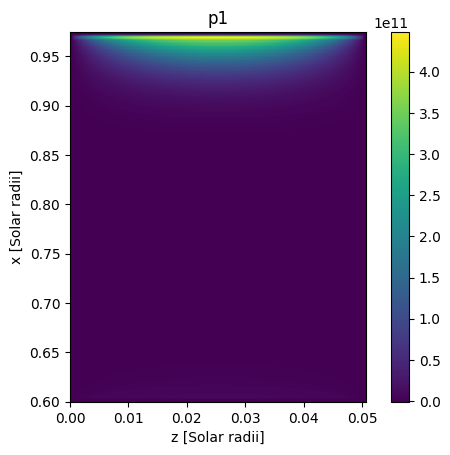

In [270]:
nz_ghost = eval(info.split("\n")[3].split(":")[1])
nz = eval(info.split("\n")[2].split(":")[1])
nx = eval(info.split("\n")[1].split(":")[1])
t = eval(info.split("\n")[0].split(":")[1])
dx = eval(info.split("\n")[4].split(":")[1])
dz = eval(info.split("\n")[5].split(":")[1])

fig, ax = plt.subplots()

R_sun = 6.957e10

p1_no_ghost = p1[nz_ghost:-1-nz_ghost+1,:]
x_extent = dx*nx/R_sun

z_0 = 0.6
z_1 = nz*dz/R_sun + 0.6

z_extent = (z_1 - z_0) * 0.8

aspect = x_extent/z_extent

im = ax.imshow(p1_no_ghost, origin="lower", extent=[0, x_extent, z_0, z_1], aspect=aspect)
colorbar = plt.colorbar(im, ax=ax)
ax.set_title("p1")
ax.set_xlabel("z [Solar radii]")
ax.set_ylabel("x [Solar radii]")

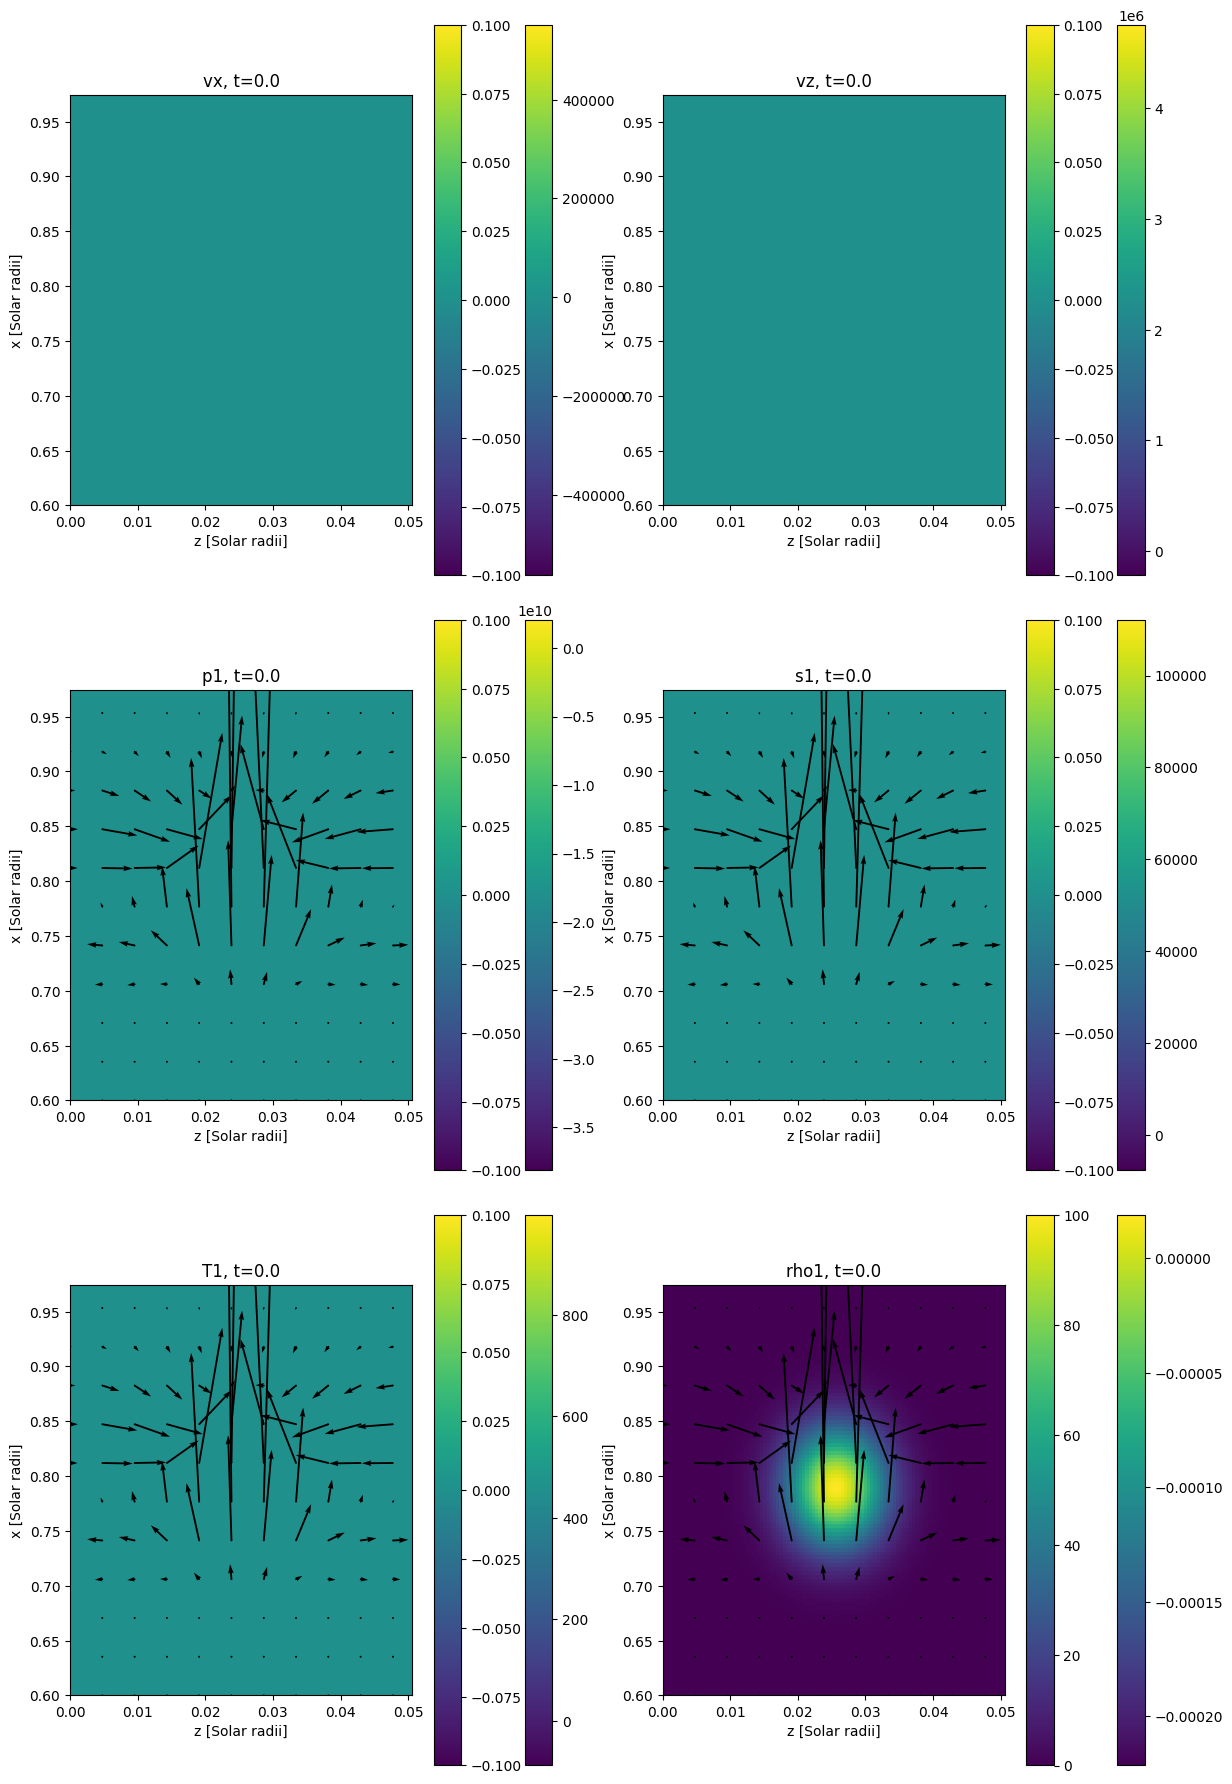

In [400]:
def get_info(info):
    t = eval(info.split("\n")[0].split(":")[1])
    nx = eval(info.split("\n")[1].split(":")[1])
    nz = eval(info.split("\n")[2].split(":")[1])
    nz_ghost = eval(info.split("\n")[3].split(":")[1])
    dx = eval(info.split("\n")[4].split(":")[1])
    dz = eval(info.split("\n")[5].split(":")[1])
    return t, nx, nz, nz_ghost, dx, dz

def plot(ax, fig, index, key, stride=1, scale=0.01, quivers=True):
    file_path = "../data/HD_2D_1/snap{}.h5".format(index)
    
    T1, rho1, p1, s1, vx, vz, info = read_fg(file_path)
    d = {"T1": T1, "rho1": rho1, "p1": p1, "s1": s1, "vx":vx, "vz":vz}
    
    t, nx, nz, nz_ghost, dx, dz = get_info(info)
    
    x_extent = dx*nx/R_sun

    z_0 = 0.6
    z_1 = nz*dz/R_sun + 0.6

    z_extent = (z_1 - z_0)

    aspect = x_extent/z_extent * 1.2
    
    d = d[key][nz_ghost:-1-nz_ghost+1,:]
    if quivers:
        vx = vx[nz_ghost:-1-nz_ghost+1,:]
        vz = vz[nz_ghost:-1-nz_ghost+1,:]

        height, width = d.shape
        Y, X = np.mgrid[0:height:stride, 0:width:stride]
        # Convert pixel indices to data coordinates
        X_data = (X * dx)/R_sun
        Y_data = (Y * dz)/R_sun+0.6  # Adding z_0 to start from the right location in the z-direction
        #print(Y_data)
        ax.quiver(X_data, Y_data, vx[::stride, ::stride], vz[::stride, ::stride], scale=scale)

    ax.set_title("{:}, t={:}".format(key, t))
    ax.set_xlabel("z [Solar radii]")
    ax.set_ylabel("x [Solar radii]")
    
    im =ax.imshow(d, origin="lower", extent=[0,x_extent,z_0,z_1], aspect=aspect)
    
    ax.set_xlim(0, x_extent)
    ax.set_ylim(z_0, z_1)
    return im


num_snaps = len(os.listdir("../data/HD_2D_1/"))-2
T1, rho1, p1, s1, vx, vz, info = read_fg("../data/HD_2D_1/snap{}.h5".format(int(5)))


stride = 10
scale = max(np.max(vx),np.max(vz))

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(12, 18))  # 3x2 grid of subplots

colorbars = [[None for _ in range(2)] for _ in range(3)]  # 3x2 grid of colorbars

# List of tuples containing the data string and quivers boolean
plot_params = [
    ("vx", False),
    ("vz", False),
    ("p1", True),
    ("s1", True),
    ("T1", True),
    ("rho1", True)
]

def init():
    for idx, (param, quiver) in enumerate(plot_params):
        i, j = divmod(idx, 2)  # Convert 1D index to 2D indices
        im = plot(axs[i, j], fig, 0, param, stride, scale, quivers=quiver)
        colorbars[i][j] = plt.colorbar(im, ax=axs[i, j])

def animate(frame):
    for idx, (param, quiver) in enumerate(plot_params):
        i, j = divmod(idx, 2)
        if colorbars[i][j] is not None:
            colorbars[i][j].remove()
        axs[i, j].clear()
        im = plot(axs[i, j], fig, frame, param, stride, scale, quivers=quiver)
        colorbars[i][j] = plt.colorbar(im, ax=axs[i, j])

fig.tight_layout()

anim = FuncAnimation(fig, animate, interval=250, frames=range(60), init_func=init)
#HTML(anim.to_jshtml())
anim.save('rho1pert.mp4', writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'])


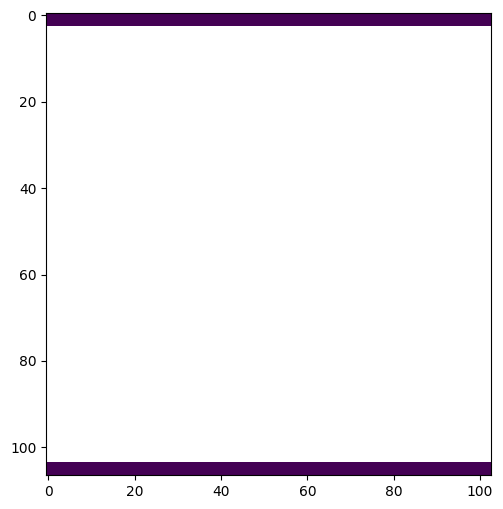

In [72]:
T1, rho1, p1, s1, vx, vz =read_fg("../data/HD_2D_1/snap2.h5")

fig,ax = plt.subplots(figsize=(6,6))

ax.imshow(vx)

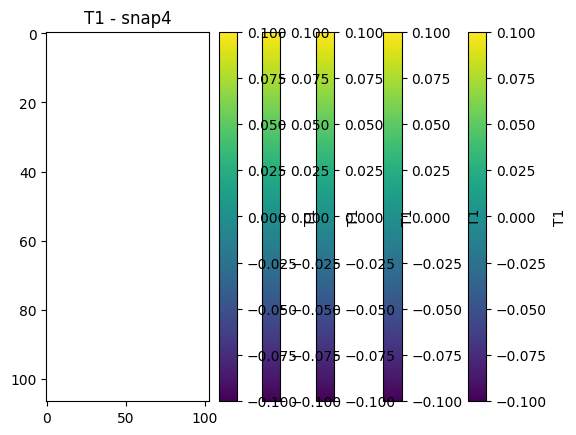

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

def animate_snap(base_filename, var_name, snap_range, pause_duration=0.5):
    """
    Animate the specified variable from the HDF5 snapshots.

    base_filename: Base path to the snap files. Should contain a '{}' placeholder for the snap number.
    var_name: Variable name, e.g. 'T1', 'rho1', etc.
    snap_range: Range of snap numbers to animate.
    pause_duration: Time (in seconds) to display each snap before moving on.
    """
    
    fig, ax = plt.subplots()

    for i in snap_range:
        # Clear previous images and colorbars
        ax.clear()

        filename = base_filename.format(i)
        data = read_fg(filename)
        var_dict = {'T1': 0, 'rho1': 1, 'p1': 2, 's1': 3, 'vx': 4, 'vz': 5}
        var_idx = var_dict[var_name]
        
        im = ax.imshow(data[var_idx], aspect='auto')
        ax.set_title(f"{var_name} - snap{i}")

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(var_name)  # set the label of the colorbar to the variable name
        
        plt.draw()
        display(fig)
        clear_output(wait=True)
        time.sleep(pause_duration)

    plt.close() # close the figure at the end to avoid duplication


animate_snap("../data/HD_2D_1/snap{}.h5", "T1", range(0,5))

AttributeError: 'Axes' object has no attribute 'colorbar'

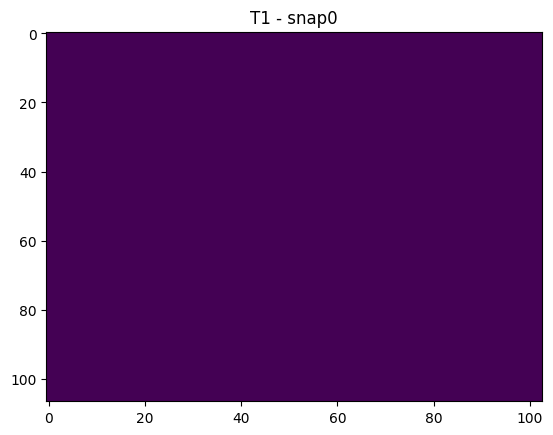

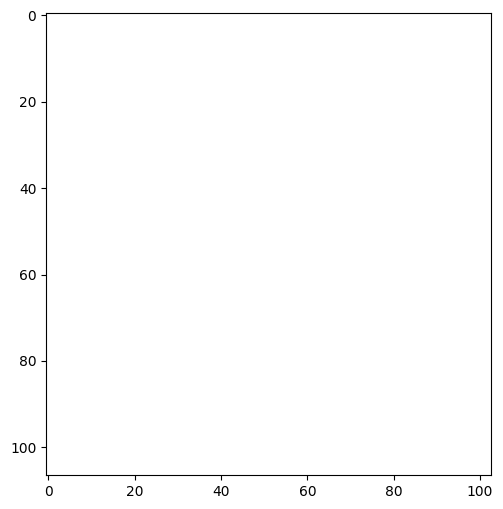

In [52]:
T1, rho1, p1, s1, vx, vz =read_fg("../data/HD_2D_1/snap5.h5")

fig,ax = plt.subplots(figsize=(6,6))

ax.imshow(T1)

In [22]:
p1

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])